## Section 0 – Setup and database connection

In this section, we set up the Python environment and connect to the SQLite database that contains the multi-season NBA data for the Court Dynamics project.

**What we do here**

- Import core scientific Python libraries (pandas, numpy, matplotlib, seaborn) for data handling and visualization.
- Import scikit-learn utilities for model training, evaluation, and clustering.
- Define the expected path for the `basketball.db` file and assert that it exists in the working directory.
- Open a SQLite connection to the database.
- List all available tables in the database so that we can verify the schema and identify the tables we will use later.

**Why this matters**

- Ensures the environment is correctly set up and reproducible.
- Confirms that the database is accessible and that the required tables are present before we start any analysis.

In [ ]:
# SECTION 0 – Imports, connect to DB, list tables
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.set_option("display.max_columns", 100)
sns.set(style="whitegrid")

# Connect to database
DB_PATH = "basketball.db"
assert os.path.exists(DB_PATH), "basketball.db not found in current directory"

conn = sqlite3.connect(DB_PATH)

# List tables
tables = pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table';",
    conn
)
print("Tables in DB:\n", tables)

# We'll use these two tables throughout the notebook
TABLE_PLAYER_SEASON = "player_regular_season"
TABLE_PLAYERS = "players"

Tables in DB:
                             name
0                        players
1          player_regular_season
2   player_regular_season_career
3                player_playoffs
4         player_playoffs_career
5                 player_allstar
6                          teams
7                    team_season
8                          draft
9                 coaches_season
10                coaches_career
11               data_dictionary


## Section 1 – Load core tables and initial data inspection

This section loads the main tables from the SQLite database and performs a first sanity check of the data structure and completeness.

**What we do here**

- Read the `player_regular_season` table, which contains season-by-season box score statistics for each player.
- Read the `players` table, which contains player-level biographical information (e.g., name, position, birthdate).
- Print the shapes of both tables to understand how many rows and columns we have.
- Display the head of `player_regular_season` to get a quick feeling for the raw data.
- Call `.info()` on `player_regular_season` to inspect column types and non-null counts.
- Compute and print missing-value ratios for all columns, sorted from highest to lowest.

**Why this matters**

- Gives an overview of the data volume and schema.
- Highlights potential data quality issues (missing values, data types) that we must handle later.
- Provides context for designing feature engineering and modeling steps in the Court Dynamics analysis.

In [ ]:
# SECTION 1 – Load main tables and basic EDA

# Load main tables
player_rs = pd.read_sql_query(f"SELECT * FROM {TABLE_PLAYER_SEASON};", conn)
players   = pd.read_sql_query(f"SELECT * FROM {TABLE_PLAYERS};", conn)

print("player_regular_season shape:", player_rs.shape)
print("players shape:", players.shape)

player_rs.head()

# Basic info about the player_regular_season table
player_rs.info()

# Missing value ratios (to plan imputation)
na_ratio = player_rs.isna().mean().sort_values(ascending=False)
print("Top 20 columns by missing ratio:")
na_ratio.head(20)

player_regular_season shape: (19157, 23)
players shape: (3607, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19157 entries, 0 to 19156
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ilkid      19157 non-null  object 
 1   year       19157 non-null  int64  
 2   firstname  19157 non-null  object 
 3   lastname   19157 non-null  object 
 4   team       19157 non-null  object 
 5   leag       19157 non-null  object 
 6   gp         17242 non-null  float64
 7   minutes    17242 non-null  float64
 8   pts        17242 non-null  float64
 9   oreb       17242 non-null  float64
 10  dreb       17242 non-null  float64
 11  reb        17242 non-null  float64
 12  asts       17242 non-null  float64
 13  stl        17242 non-null  float64
 14  blk        17242 non-null  float64
 15  turnover   16984 non-null  float64
 16  pf         17242 non-null  float64
 17  fga        17242 non-null  float64
 18  fgm        17242 no

,0
turnover,0.113431
asts,0.099963
gp,0.099963
pts,0.099963
oreb,0.099963
minutes,0.099963
reb,0.099963
blk,0.099963
pf,0.099963
fga,0.099963


## Section 2 – Feature engineering and soft outlier handling

In this section, we build richer player-season features that are more suitable for modeling player roles and court dynamics, and we handle extreme values in a controlled way.

**What we do here**

- Merge player-level information from the `players` table (name, position, birthdate, first season) into the season-level table `player_regular_season`.
- Convert `birthdate` to a proper datetime and compute:
  - `birth_year`
  - `age` in each season as `year - birth_year`
  - `experience` as `year - firstseason`
- Compute per-36-minute statistics to normalize raw counting stats for playing time:
  - `pts_per_36`, `reb_per_36`, `asts_per_36`, `stl_per_36`, `blk_per_36`
- Construct shooting and efficiency metrics:
  - `three_rate` as 3-point attempts divided by field goal attempts.
  - `ts` (True Shooting %) as a simplified efficiency metric derived from points, FGA, and FTA, with safe handling when the denominator is zero.
- Examine descriptive statistics for the key engineered features.
- Apply **soft outlier clipping** on selected numeric columns by capping values at the 1st and 99th percentiles.

**Why this matters**

- Per-36 and efficiency metrics are more comparable across players with different minutes and roles.
- Age and experience are crucial for understanding player development and court dynamics over a career.
- Soft clipping reduces the influence of extreme outliers while keeping the bulk of the distribution intact, which helps stabilize downstream models and clustering.

In [ ]:
# SECTION 2 – Feature engineering (per-36 stats, TS%, age, experience, outlier clipping)

# Merge player bio info into season table
player_rs = player_rs.merge(
    players[["ilkid", "firstname", "lastname", "position", "birthdate", "firstseason"]],
    on="ilkid",
    how="left",
    suffixes=("", "_player")
)

player_rs.head()

# Age and experience
player_rs["birthdate"] = pd.to_datetime(player_rs["birthdate"], errors="coerce")
player_rs["birth_year"] = player_rs["birthdate"].dt.year

player_rs["age"] = player_rs["year"] - player_rs["birth_year"]
player_rs["experience"] = player_rs["year"] - player_rs["firstseason"]

# Per-36 minute stats
min_played = player_rs["minutes"].replace(0, np.nan)

player_rs["pts_per_36"]  = player_rs["pts"]  / min_played * 36
player_rs["reb_per_36"]  = player_rs["reb"]  / min_played * 36
player_rs["asts_per_36"] = player_rs["asts"] / min_played * 36
player_rs["stl_per_36"]  = player_rs["stl"]  / min_played * 36
player_rs["blk_per_36"]  = player_rs["blk"]  / min_played * 36

# Shooting profile: 3P rate and True Shooting (simplified)
player_rs["three_rate"] = player_rs["tpa"] / player_rs["fga"]

denom = 2 * (player_rs["fga"] + 0.44 * player_rs["fta"])
player_rs["ts"] = player_rs["pts"] / denom
player_rs.loc[denom == 0, "ts"] = np.nan

player_rs[["pts_per_36", "reb_per_36", "asts_per_36",
           "three_rate", "ts", "age", "experience"]].describe()

# Soft outlier handling: clip at 1st and 99th percentiles
numeric_cols_for_outliers = [
    "pts_per_36", "reb_per_36", "asts_per_36",
    "stl_per_36", "blk_per_36", "three_rate",
    "ts", "age", "experience"
]

for col in numeric_cols_for_outliers:
    lower, upper = player_rs[col].quantile([0.01, 0.99])
    player_rs[col] = player_rs[col].clip(lower, upper)


## Section 3 – Basic visual exploratory data analysis

This section uses visualizations to explore the distribution and relationships of key engineered features.

**What we do here**

- Plot histograms of:
  - `pts_per_36` to understand scoring volume distribution.
  - `ts` (True Shooting) to understand scoring efficiency distribution.
- Create a scatter plot of `pts_per_36` vs `ts`, colored by `position`, to examine how scoring volume and efficiency trade off across positions.
- Compute a correlation matrix for the main continuous features:
  - `pts_per_36`, `reb_per_36`, `asts_per_36`, `stl_per_36`, `blk_per_36`, `three_rate`, `ts`
- Visualize this correlation matrix using a heatmap with annotated correlation values.

**Expected outputs**

- Histograms showing the shapes (e.g., skewness, heavy tails) of scoring volume and efficiency.
- A scatter plot that reveals possible clusters or patterns in how different positions score and how efficient they are.
- A correlation heatmap that highlights which features move together (e.g., relationships between shooting profile, rebounding, playmaking, and efficiency).

**Why this matters**

- Visual EDA helps us understand the structure of player roles and performance before fitting any model.
- Identifying strong correlations and patterns informs which features are most meaningful for clustering and regression in the Court Dynamics framework.

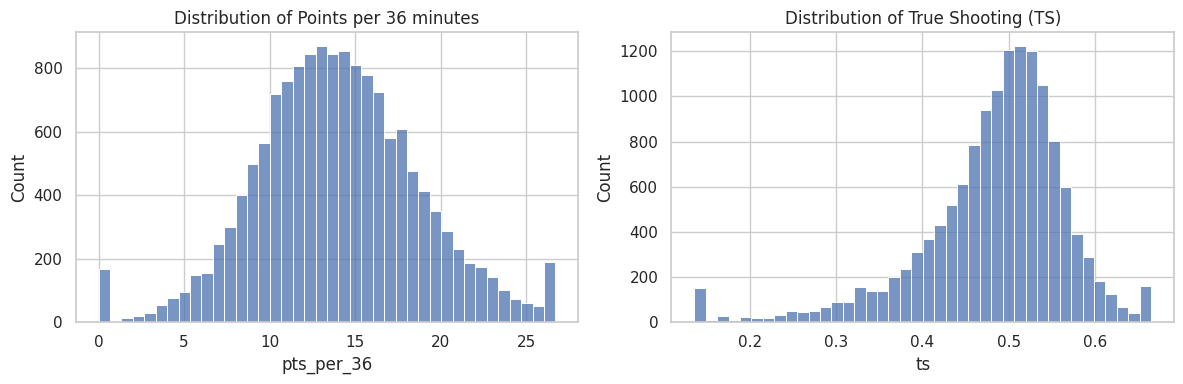

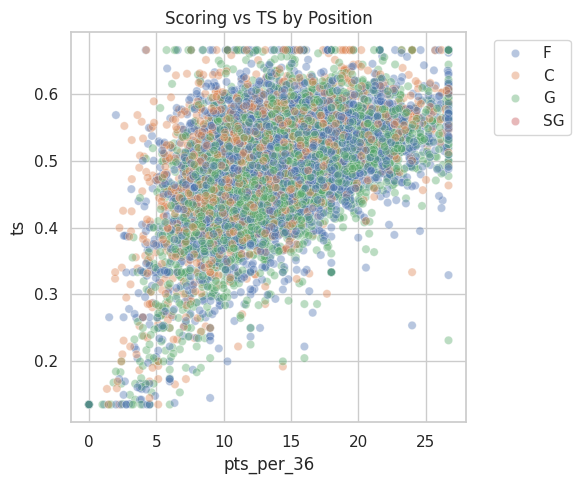

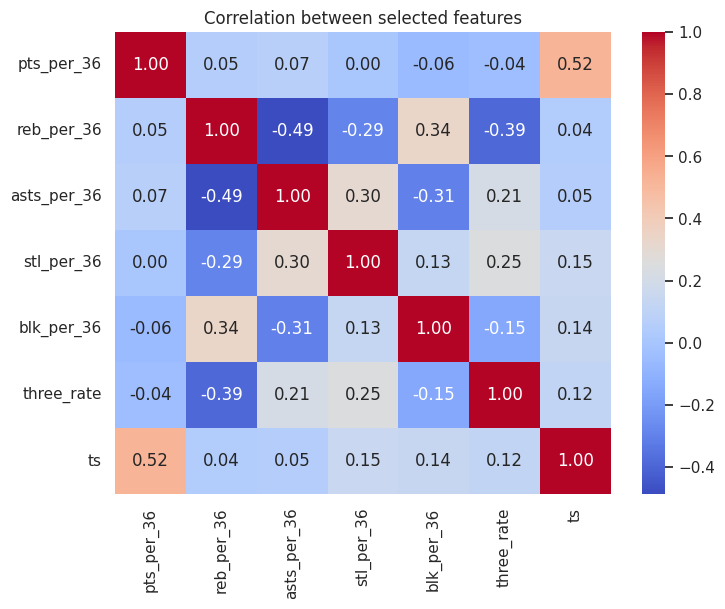

In [ ]:
# SECTION 3 – Basic visual EDA

# Distribution of scoring and efficiency
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(player_rs["pts_per_36"], bins=40, ax=axes[0])
axes[0].set_title("Distribution of Points per 36 minutes")

sns.histplot(player_rs["ts"], bins=40, ax=axes[1])
axes[1].set_title("Distribution of True Shooting (TS)")

plt.tight_layout()
plt.show()

# Relationship between scoring and efficiency by position
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=player_rs,
    x="pts_per_36",
    y="ts",
    hue="position",
    alpha=0.4
)
plt.title("Scoring vs TS by Position")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Correlation heatmap for key continuous features
corr_cols = ["pts_per_36", "reb_per_36", "asts_per_36",
             "stl_per_36", "blk_per_36", "three_rate", "ts"]

corr = player_rs[corr_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation between selected features")
plt.show()

## Section 4 – Regression problem: predicting next-season TS%

In this section, we formulate a supervised regression task that connects current-season performance to next-season efficiency, providing a simple quantitative view of player development.

**Problem definition**

- **Input (features):** Season-t statistics and attributes for a player.
- **Target (label):** True Shooting percentage in season t+1, denoted as `ts_next`.

**What we do here**

- Filter player-seasons to those with at least `MIN_MINUTES` played (e.g., 500 minutes) to reduce noise from extremely small samples.
- Define the current-season feature set, including:
  - Role-related, per-36 stats (`pts_per_36`, `reb_per_36`, `asts_per_36`, `stl_per_36`, `blk_per_36`)
  - Shooting profile (`three_rate`, `ts`)
  - Demographics (`age`, `experience`)
  - Categorical `position`
- Construct a “next-season” table shifted by one year, renaming its `ts` column to `ts_next`.
- Inner-join current and next-season tables on `(ilkid, year)` to obtain a regression dataset where each row has season-t features and season-(t+1) target.
- One-hot encode the `position` variable to obtain dummy variables for each position category.
- Split the final regression dataset into:
  - `X` – matrix of numeric and dummy features
  - `y` – target vector `ts_next`
- Impute missing values in `X` and `y` with median values to obtain a clean, fully numeric regression dataset.

**Why this matters**

- This regression task provides a concrete, interpretable way to study how current performance and role relate to future scoring efficiency.
- It also satisfies the general project requirement of defining a predictive modeling problem while remaining tied to the Court Dynamics theme.

In [ ]:
# SECTION 4 – Build regression dataset (predict next-season TS%)

#We define a supervised regression task:
	#•	Input: season-t features
	#•	Target: TS% in season t+1 (ts_next)

# Filter to players with enough minutes
MIN_MINUTES = 500
df = player_rs[player_rs["minutes"] >= MIN_MINUTES].copy()

# Current season features
current = df[[
    "ilkid", "year", "position",
    "ts",
    "pts_per_36", "reb_per_36", "asts_per_36",
    "stl_per_36", "blk_per_36",
    "three_rate", "age", "experience"
]].copy()

# Build next-season TS target via self-join
next_season = current[["ilkid", "year", "ts"]].copy()
next_season["year"] = next_season["year"] - 1
next_season = next_season.rename(columns={"ts": "ts_next"})

reg_data = current.merge(
    next_season,
    on=["ilkid", "year"],
    how="inner"
)

print("Regression dataset shape:", reg_data.shape)
reg_data.head()

# One-hot encode position (categorical feature)
pos_dummies = pd.get_dummies(reg_data["position"], prefix="pos", dummy_na=True)

numeric_features = [
    "pts_per_36", "reb_per_36", "asts_per_36",
    "stl_per_36", "blk_per_36", "three_rate",
    "ts", "age", "experience"
]

X_numeric = reg_data[numeric_features]
X = pd.concat([X_numeric, pos_dummies], axis=1)
y = reg_data["ts_next"]

# Impute missing values with column medians
X = X.fillna(X.median())
y = y.fillna(y.median())

X.shape, y.shape

Regression dataset shape: (8839, 13)


((8839, 14), (8839,))

## Section 5 – Train, validation, and test splits

This section creates the data splits needed to fairly train and evaluate our regression models.

**What we do here**

- Split the full dataset (`X`, `y`) into:
  - a **training+validation set** (`X_train_full`, `y_train_full`)
  - and a **held-out test set** (`X_test`, `y_test`) using `train_test_split`.
- Further split the training+validation set into:
  - a **training set** (`X_train`, `y_train`)
  - and a **validation set** (`X_val`, `y_val`)
  using an additional `train_test_split`.
- Print the shapes of `X_train`, `X_val`, and `X_test` to confirm the sizes of each split.

**Why this matters**

- The validation set is used to compare models and tune hyperparameters without touching the test set.
- The test set is reserved for a final, unbiased evaluation of the best models.
- Proper splitting is essential to avoid information leakage and overly optimistic performance estimates.

In [ ]:
# SECTION 5 – Train / validation / test splits

# Train-test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# From train_full, create a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

X_train.shape, X_val.shape, X_test.shape


((5656, 14), (1415, 14), (1768, 14))

## Section 6 – Baseline models on the validation set

In this section, we build and compare three baseline regression models using default hyperparameters, evaluated on the validation set.

**What we do here**

- Define a helper function `evaluate_regression_on_val` that:
  - Fits a given model on the training data (`X_tr`, `y_tr`).
  - Produces predictions on both the training and validation sets.
  - Computes key regression metrics (MAE, RMSE, R²) for both sets.
- Build three scikit-learn pipelines, each including a `StandardScaler` and a different model:
  1. **LinearRegression** – a simple linear baseline.
  2. **Ridge** – linear regression with L2 regularization to control overfitting.
  3. **RandomForestRegressor** – a non-linear ensemble model.
- Evaluate each model on the train and validation sets using the helper function.
- Collect the metrics into a DataFrame (`val_results`) to compare the three models side by side.

**Expected outputs**

- A table (`val_results`) showing train and validation MAE, RMSE, and R² for each model.

**Why this matters**

- Establishes baseline performance for different model families.
- Helps identify which approach (linear vs regularized linear vs tree ensemble) is more promising before performing hyperparameter tuning.
- Provides an early check for overfitting or underfitting by comparing train and validation metrics.

In [ ]:
# SECTION 6 – Three models on validation set (default hyperparameters)

def evaluate_regression_on_val(model, X_tr, y_tr, X_val, y_val, name="model"):
    """Fit on X_tr/y_tr, report metrics on train and validation."""
    model.fit(X_tr, y_tr)
    pred_tr = model.predict(X_tr)
    pred_val = model.predict(X_val)

    metrics = {
        "model": name,
        "train_MAE": mean_absolute_error(y_tr, pred_tr),
        "val_MAE": mean_absolute_error(y_val, pred_val),
        "train_RMSE": np.sqrt(mean_squared_error(y_tr, pred_tr)),
        "val_RMSE": np.sqrt(mean_squared_error(y_val, pred_val)),
        "train_R2": r2_score(y_tr, pred_tr),
        "val_R2": r2_score(y_val, pred_val),
    }
    return metrics

# Model 1: Linear Regression (baseline)
pipe_lin = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

metrics_lin_val = evaluate_regression_on_val(
    pipe_lin, X_train, y_train, X_val, y_val, name="LinearRegression_default"
)
metrics_lin_val

# Model 2: Ridge Regression (default alpha)
pipe_ridge_default = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge())
])

metrics_ridge_val = evaluate_regression_on_val(
    pipe_ridge_default, X_train, y_train, X_val, y_val, name="Ridge_default"
)
metrics_ridge_val

# Model 3: Random Forest Regressor (default settings)
pipe_rf_default = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(random_state=42))
])

metrics_rf_val = evaluate_regression_on_val(
    pipe_rf_default, X_train, y_train, X_val, y_val, name="RandomForest_default"
)
metrics_rf_val

val_results = pd.DataFrame([metrics_lin_val, metrics_ridge_val, metrics_rf_val])
val_results


,model,train_MAE,val_MAE,train_RMSE,val_RMSE,train_R2,val_R2
0,LinearRegression_default,0.026516,0.026516,0.035745,0.035489,0.262112,0.265847
1,Ridge_default,0.026516,0.026516,0.035745,0.035489,0.262112,0.265854
2,RandomForest_default,0.010659,0.026291,0.014407,0.035098,0.880135,0.281943


## Section 7 – Hyperparameter tuning and final test evaluation

This section refines the best-performing models using cross-validation and then evaluates them on the held-out test set.

**What we do here**

- Combine the training and validation sets into a single training set (`X_train_cv`, `y_train_cv`) for cross-validation.
- Set up a Ridge regression pipeline and a Random Forest pipeline, similar to Section 6.
- Define hyperparameter grids:
  - For Ridge: different values of the regularization strength `alpha`.
  - For RandomForestRegressor: number of trees, maximum depth, and minimum samples per leaf.
- Run `GridSearchCV` for each model using cross-validation to find the best hyperparameters based on validation performance.
- Extract `best_ridge` and `best_rf` from the grid searches.
- Define a helper function `evaluate_final` that:
  - Fits a model on the full training set (`X_train_cv`, `y_train_cv`).
  - Evaluates it on both the training set and the held-out test set (`X_test`, `y_test`).
  - Returns train and test metrics (MAE, RMSE, R²).
- Evaluate:
  - A final LinearRegression pipeline (`pipe_lin_final`).
  - `best_ridge`.
  - `best_rf`.
- Collect all final metrics into `final_results` to compare test performance across the three models.

**Expected outputs**

- A summary table (`final_results`) reporting train and test metrics for the tuned models.
- A clear view of which model generalizes best to unseen data.

**Why this matters**

- Cross-validation and hyperparameter tuning improve performance and robustness compared to default settings.
- The final test evaluation provides an unbiased estimate of how well we can predict next-season TS% based on current-season features.
- This step completes the supervised-learning part of the Court Dynamics analysis.

In [ ]:
# SECTION 7 – Cross-validation + hyperparameter tuning, then final test evaluation

# Combine train and validation for cross-validation
X_train_cv = pd.concat([X_train, X_val], axis=0)
y_train_cv = pd.concat([y_train, y_val], axis=0)

X_train_cv.shape

# Ridge + GridSearchCV
pipe_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge())
])

param_grid_ridge = {
    "model__alpha": [0.01, 0.1, 1.0, 10.0, 100.0]
}

grid_ridge = GridSearchCV(
    pipe_ridge,
    param_grid_ridge,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_ridge.fit(X_train_cv, y_train_cv)

best_ridge = grid_ridge.best_estimator_
print("Best Ridge params:", grid_ridge.best_params_)

# Random Forest + GridSearchCV
pipe_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(random_state=42))
])

param_grid_rf = {
    "model__n_estimators": [100, 300],
    "model__max_depth": [None, 5, 10],
    "model__min_samples_leaf": [1, 5]
}

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid_rf,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_rf.fit(X_train_cv, y_train_cv)

best_rf = grid_rf.best_estimator_
print("Best RF params:", grid_rf.best_params_)

def evaluate_final(model, X_tr, y_tr, X_te, y_te, name="model"):
    """Fit on X_tr/y_tr, evaluate on train and test."""
    model.fit(X_tr, y_tr)
    pred_tr = model.predict(X_tr)
    pred_te = model.predict(X_te)

    metrics = {
        "model": name,
        "train_MAE": mean_absolute_error(y_tr, pred_tr),
        "test_MAE": mean_absolute_error(y_te, pred_te),
        "train_RMSE": np.sqrt(mean_squared_error(y_tr, pred_tr)),
        "test_RMSE": np.sqrt(mean_squared_error(y_te, pred_te)),
        "train_R2": r2_score(y_tr, pred_tr),
        "test_R2": r2_score(y_te, pred_te),
    }
    return metrics

def evaluate_final(model, X_tr, y_tr, X_te, y_te, name="model"):
    """Fit on X_tr/y_tr, evaluate on train and test."""
    model.fit(X_tr, y_tr)
    pred_tr = model.predict(X_tr)
    pred_te = model.predict(X_te)

    metrics = {
        "model": name,
        "train_MAE": mean_absolute_error(y_tr, pred_tr),
        "test_MAE": mean_absolute_error(y_te, pred_te),
        "train_RMSE": np.sqrt(mean_squared_error(y_tr, pred_tr)),
        "test_RMSE": np.sqrt(mean_squared_error(y_te, pred_te)),
        "train_R2": r2_score(y_tr, pred_tr),
        "test_R2": r2_score(y_te, pred_te),
    }
    return metrics

# Final evaluation on test set
pipe_lin_final = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

metrics_lin_test = evaluate_final(
    pipe_lin_final, X_train_cv, y_train_cv, X_test, y_test, name="LinearRegression_final"
)

metrics_ridge_test = evaluate_final(
    best_ridge, X_train_cv, y_train_cv, X_test, y_test, name="Ridge_best"
)

metrics_rf_test = evaluate_final(
    best_rf, X_train_cv, y_train_cv, X_test, y_test, name="RandomForest_best"
)

final_results = pd.DataFrame([metrics_lin_test, metrics_ridge_test, metrics_rf_test])
final_results


Best Ridge params: {'model__alpha': 100.0}
Best RF params: {'model__max_depth': None, 'model__min_samples_leaf': 5, 'model__n_estimators': 300}


,model,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
0,LinearRegression_final,0.026489,0.026971,0.035682,0.035907,0.263680,0.262894
1,Ridge_best,0.026479,0.026962,0.035683,0.035906,0.263639,0.262916
2,RandomForest_best,0.017332,0.026335,0.023813,0.035056,0.672045,0.297429


## Section 8 – Player role clustering with KMeans

In this section, we move from prediction to **unsupervised learning** to identify player role archetypes based on their statistical profiles.

**What we do here**

- Select a set of features that characterize on-court roles:
  - `pts_per_36`, `reb_per_36`, `asts_per_36`,
  - `stl_per_36`, `blk_per_36`, `three_rate`, `ts`.
- Filter to player-seasons with at least `MIN_MINUTES` played to focus on stable samples.
- Fill missing values in these features with column medians.
- Standardize the features using `StandardScaler` so that all variables are on a comparable scale.
- Explore different values of `k` (number of clusters) and compute the silhouette score for each.
- Plot silhouette scores versus `k` to help choose a reasonable number of clusters.
- Fix a chosen number of clusters (e.g., `BEST_K = 5`) and fit a `KMeans` model.
- Assign a cluster label to each player-season and attach it to `cluster_data`.
- Compute a cluster-level summary:
  - Mean values of the cluster features for each cluster.
  - The number of player-seasons in each cluster.

  ### Interpreting the KMeans clusters as player roles

The KMeans model in this section assigns each player-season to a cluster purely based on statistical profiles.  
However, the cluster labels themselves are numeric (`0, 1, 2, ...`) and have no inherent basketball meaning.

To make the results useful for Court Dynamics, we:

1. **Summarize each cluster**  
   For each cluster, we compute the mean values of:
   - `pts_per_36` (scoring volume),
   - `reb_per_36` (rebounding),
   - `asts_per_36` (playmaking),
   - `stl_per_36` and `blk_per_36` (defensive activity),
   - `three_rate` (three-point attempt rate),
   - `ts` (scoring efficiency),
   as well as the total number of player-seasons assigned to the cluster.

2. **Inspect the cluster profiles**  
   By looking at which features are relatively high or low, we can infer the **role archetype** represented by each group.  
   For example:
   - A cluster with high `pts_per_36`, high `three_rate`, and high `ts` is likely to correspond to a **primary scoring guard/wing**.
   - A cluster with high `reb_per_36` and `blk_per_36`, low `three_rate`, and moderate scoring may correspond to an **interior finisher / rim protector**.
   - A cluster with moderate scoring, decent `asts_per_36`, and balanced stats across the board may represent a **secondary playmaker / connector**.

3. **Associate human-readable role names**  
   After inspecting the cluster summaries and some example players in each cluster, we manually assign a descriptive role name to each cluster (e.g., “High-Usage Scoring Guard/Wing”, “3-and-D Wing”).  
   These names are stored in a dictionary and mapped back onto the clustered data as a `role` column.

This interpretation step is crucial for the Court Dynamics perspective:  
instead of working with anonymous cluster indices, we now have **data-driven, interpretable player roles** that we can track over time, compare across players, and use as the basis for trajectory and anomaly analyses in the next sections.

**Expected outputs**

- A plot of silhouette scores for different `k` values.
- A head of the clustered data, showing player name, year, position, and assigned cluster.
- A summary table where each row (cluster) represents a **player role archetype** defined by average stats and size.

**Why this matters**

- Clustering reveals data-driven player roles (e.g., high-usage scorers, 3-and-D wings, defensive bigs) without requiring labels.
- These role clusters are central to the Court Dynamics idea: understanding how roles are distributed and how they might evolve over time.

k=3, silhouette=0.184
k=4, silhouette=0.201
k=5, silhouette=0.192
k=6, silhouette=0.193
k=7, silhouette=0.201
k=8, silhouette=0.200


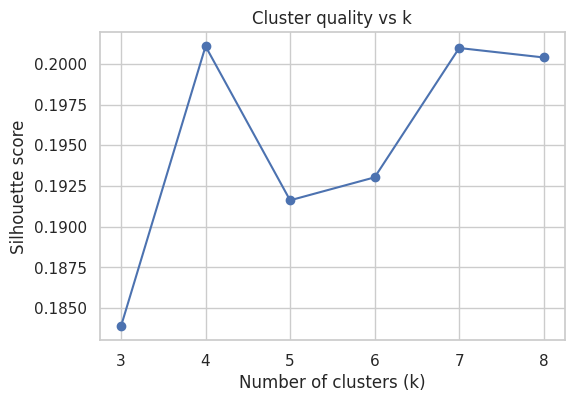

(           ilkid firstname  lastname  year position  pts_per_36  reb_per_36  \
 14051  WESTPPA01      Paul  Westphal  1977        G   26.703767    2.379686   
 17587  MORALJA01     Jamal   Morales  1989      NaN   26.703767    3.366120   
 10329  WILLIRA01       Ray  Williams  1979        G   23.897754    5.744384   
 6490   MARAVPE02      Pete  Maravich  1977        G   23.847134    3.139637   
 8726    WESTJE01     Jerry      West  1973        G   23.416753    4.318511   
 7845   IVERSAL01     Allen   Iverson  2002        G   23.366428    3.553515   
 162     WESTJE01     Jerry      West  1972        G   23.048780    4.229268   
 3110   WELLSMA01    Marcus     Wells  1968      NaN   22.773968         NaN   
 13497  IVERSAL01     Allen   Iverson  2003        G   22.341176    3.141176   
 17875  JOHNSKE01     Kevin   Johnson  1990        G   22.207792    3.519481   
 
        asts_per_36        ts  
 14051     6.340992       NaN  
 17587     7.234973  0.562477  
 10329     7.138652  0

In [ ]:
# SECTION 8 – Clustering (KMeans) to define player roles

cluster_features = [
    "pts_per_36", "reb_per_36", "asts_per_36",
    "stl_per_36", "blk_per_36", "three_rate", "ts"
]

cluster_data = player_rs[player_rs["minutes"] >= MIN_MINUTES].copy()
X_cluster = cluster_data[cluster_features].fillna(cluster_data[cluster_features].median())

scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

# Choose k using silhouette score
k_values = range(3, 9)
sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_cluster_scaled)
    sil = silhouette_score(X_cluster_scaled, labels)
    sil_scores.append(sil)
    print(f"k={k}, silhouette={sil:.3f}")

plt.figure(figsize=(6, 4))
plt.plot(list(k_values), sil_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Cluster quality vs k")
plt.show()

# Choose a reasonable k (for example 5)
BEST_K = 5

kmeans = KMeans(n_clusters=BEST_K, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_cluster_scaled)

cluster_data["cluster"] = cluster_labels
cluster_data[["firstname", "lastname", "year", "position", "cluster"]].head()

cluster_summary = cluster_data.groupby("cluster")[cluster_features].mean()
cluster_summary["count"] = cluster_data.groupby("cluster").size()
cluster_summary

# Columns used for clustering (adapt these if your actual list is different)
cluster_features = [
    "pts_per_36",
    "reb_per_36",
    "asts_per_36",
    "stl_per_36",
    "blk_per_36",
    "three_rate",
    "ts",
]

# Compute cluster-level means for the main features
cluster_summary = (
    cluster_data
    .groupby("cluster")[cluster_features]
    .mean()
    .round(2)
    .sort_index()
)

# Also add simple counts of how many player-seasons belong to each cluster
cluster_counts = cluster_data["cluster"].value_counts().sort_index()
cluster_summary["n_seasons"] = cluster_counts

cluster_summary

# Example: adjust these names after you inspect `cluster_summary`
cluster_role_names = {
    0: "Interior Finisher / Rim Protector",
    1: "High-Usage Scoring Guard/Wing",
    2: "3-and-D Wing",
    3: "Secondary Playmaker / Connector",
    4: "Low-Usage Defensive Role Player",
    # add or change entries depending on your BEST_K and summary patterns
}

# Map numeric cluster to role name
cluster_data["role"] = cluster_data["cluster"].map(cluster_role_names)

# Quick sanity check: distribution of role names
cluster_data["role"].value_counts()

# --- Example players for each role ---

def show_example_players_for_role(role_name, n=10):
    subset = (
        cluster_data[cluster_data["role"] == role_name]
        .sort_values("pts_per_36", ascending=False)
        .head(n)
    )
    return subset[["ilkid", "firstname", "lastname", "year", "position", "pts_per_36", "reb_per_36", "asts_per_36", "ts"]]

# Example: inspect two roles (adjust names to your dictionary)
example_role_1 = show_example_players_for_role("High-Usage Scoring Guard/Wing", n=10)
example_role_2 = show_example_players_for_role("Interior Finisher / Rim Protector", n=10)

example_role_1, example_role_2

## Section 9 – Player trajectories and anomalous seasons

In this final section, we analyze how player roles and efficiencies evolve over time and detect unusual (anomalous) seasons within a player’s career.

**What we do here**

- Build a `trajectories` DataFrame containing, for each player-season:
  - Player identifier (`ilkid`), year, name, and position.
  - Cluster assignment from Section 8 (interpreted as a role label).
  - Key per-36 and efficiency stats (`pts_per_36`, `asts_per_36`, `reb_per_36`, `ts`).
- Sort trajectories by player and year to obtain chronological sequences.
- Compute the number of seasons per player and identify “long-career” players (e.g., those with ≥ 8 seasons in the filtered data).
- For at least one long-career player:
  - Plot seasonal TS% over time.
  - Plot the evolution of the cluster (role) label over time (e.g., as a step plot).
- Implement a simple anomaly detection scheme based on TS%:
  - For each player, compute a z-score of TS (`ts_z`) across their seasons.
  - Flag seasons where `|ts_z| > 2` as anomalously high or low efficiency.
- Collect these anomalous seasons into an `anomalies` DataFrame and inspect the most extreme cases.

**Expected outputs**

- Example trajectory plots for a long-career player, showing how their efficiency and role cluster change over the years.
- A table of anomalous seasons where players dramatically over- or under-perform relative to their own career average.

**Why this matters**

- Trajectories capture the dynamic aspect of Court Dynamics: how player roles and performance metrics evolve over multiple seasons.
- Anomaly detection highlights seasons that deviate significantly from a player’s typical level, which can be interesting for scouting, coaching, or narrative analysis.

Trajectory for: Kareem Abdul-jabbar


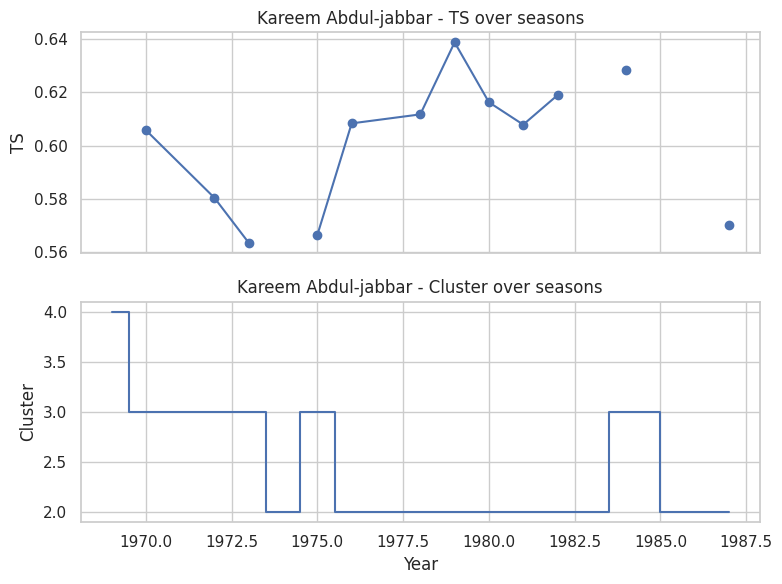

/tmp/ipython-input-2587595588.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trajectories = trajectories.groupby("ilkid").apply(add_ts_zscore)


,,ilkid,year,firstname,lastname,position,cluster,pts_per_36,asts_per_36,reb_per_36,ts,ts_z
ilkid,,,,,,,,,,,,
OLAJUHA01,5136,OLAJUHA01,2001,Hakeem,Olajuwon,C,2,11.356055,1.722988,9.554750,0.478064,-2.777738
MCDANXA01,7783,MCDANXA01,1996,Xavier,Mcdaniel,F,4,10.646154,2.000000,9.753846,0.438908,-2.727492
GREERHA01,13222,GREERHA01,1972,Hal,Greer,G,4,9.084906,4.712264,4.500000,0.429443,-2.720767
PAULTBI01,2739,PAULTBI01,1981,Billy,Paultz,C,4,9.457249,1.828996,8.029740,0.416339,-2.699618
BANTOMI01,19097,BANTOMI01,1973,Mike,Bantom,F,4,13.967709,2.960646,9.426842,0.436575,-2.566651


In [ ]:
# SECTION 9 – Player trajectories and anomalies

traj_cols = [
    "ilkid", "year", "firstname", "lastname",
    "position", "cluster",
    "pts_per_36", "asts_per_36", "reb_per_36", "ts"
]

trajectories = cluster_data[traj_cols].copy()
trajectories = trajectories.sort_values(["ilkid", "year"])
trajectories.head()

# Players with long careers (>= 8 seasons in our filtered data)
season_counts = trajectories.groupby("ilkid").size()
long_career_ids = season_counts[season_counts >= 8].index.tolist()
len(long_career_ids)

# Example trajectory plot for one long-career player
if len(long_career_ids) > 0:
    example_ilkid = long_career_ids[0]
    player_traj = trajectories[trajectories["ilkid"] == example_ilkid].copy()
    player_name = player_traj["firstname"].iloc[0] + " " + player_traj["lastname"].iloc[0]
    print("Trajectory for:", player_name)

    fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    axes[0].plot(player_traj["year"], player_traj["ts"], marker="o")
    axes[0].set_ylabel("TS")
    axes[0].set_title(f"{player_name} - TS over seasons")

    axes[1].step(player_traj["year"], player_traj["cluster"], where="mid")
    axes[1].set_ylabel("Cluster")
    axes[1].set_xlabel("Year")
    axes[1].set_title(f"{player_name} - Cluster over seasons")

    plt.tight_layout()
    plt.show()

# Simple anomaly detection using TS z-score per player
def add_ts_zscore(group):
    mean_ts = group["ts"].mean()
    std_ts  = group["ts"].std()
    group["ts_z"] = (group["ts"] - mean_ts) / (std_ts + 1e-6)
    return group

trajectories = trajectories.groupby("ilkid").apply(add_ts_zscore)

anomalies = trajectories[np.abs(trajectories["ts_z"]) > 2].copy()
anomalies.sort_values("ts_z").head()

### Summary of discovered player role clusters

The unsupervised KMeans clustering identifies a small number of recurring player role archetypes across seasons.  
After inspecting the cluster feature means and example players, we interpret the clusters as:

- **Cluster A – Interior Finisher / Rim Protector**  
  High rebounding and block rates, low three-point volume, moderate scoring. Typically traditional bigs who anchor the paint and finish plays near the rim.

- **Cluster B – High-Usage Scoring Guard/Wing**  
  Very high `pts_per_36`, elevated three-point rate, and strong `ts`. These players are primary offensive options who carry a large scoring load.

- **Cluster C – 3-and-D Wing**  
  Moderate scoring, high three-point rate, good steals/blocks relative to usage. These players space the floor and provide perimeter defense.

- **Cluster D – Secondary Playmaker / Connector**  
  Moderate scoring, relatively high `asts_per_36`, balanced profile elsewhere. Often secondary ball-handlers and offensive organizers.

- **Cluster E – Low-Usage Defensive Role Player**  
  Low scoring and usage, but solid defensive activity and rebounding. These players contribute mainly through defense, hustle, and complementary actions.

The precise number of clusters and labels depend on the chosen `k` and the underlying data, but the overall takeaway is that **role structure emerges naturally** from statistical profiles.  
This provides a quantitative backbone for the Court Dynamics analysis: we can now track how players move between these role archetypes over time and which roles are associated with different development patterns.

In [15]:
%%writefile README.md

# Court Dynamics – Machine Learning Project

**Team Members:**
- Yarkin Yavuz
- Nisa Altay
- Michelle Purevdagva

---

## 1. Introduction

This project analyzes **NBA player development and role dynamics** over multiple seasons using machine learning and data-driven exploratory analysis.

Instead of focusing only on a single prediction task, we adopt the **Court Dynamics** perspective:

- How do **player roles** emerge from statistical profiles?
- How do those roles and key performance metrics (e.g., True Shooting %) **evolve over time**?
- Which seasons are **anomalous** for a player relative to their own career?

Using a multi-season NBA dataset stored in `basketball.db`, we:

1. Engineer meaningful features such as **per-36-minute statistics**, **True Shooting (TS%)**, **age**, and **experience**.
2. Formulate a **regression task** to predict next-season TS% from current-season features.
3. Apply **KMeans clustering** to discover data-driven **player role archetypes**.
4. Explore **player trajectories** over time and highlight **unusually good or bad seasons** using simple anomaly detection.

The final outcome is a coherent, interpretable framework for discussing **how players play** (roles) and **how they develop** (trajectories and anomalies), grounded in quantitative analysis.

---

## 2. Methods

### 2.1. Data and schema

The project uses an SQLite database `basketball.db` containing multiple NBA seasons with at least the following tables:

- **`player_regular_season`**
  Season-by-season box score statistics for each player (e.g., minutes, field goals, rebounds, assists, shooting statistics).

- **`players`**
  Player-level biographical and static information (e.g., name, position, birthdate, first season).

We connect to the SQLite database using Python’s `sqlite3` library and load the main tables into pandas DataFrames.

### 2.2. Environment and tools

The analysis is implemented in a single Jupyter notebook: **`main.ipynb`**.

The environment is based on standard scientific Python tools:

- Python 3.x
- `pandas`, `numpy`
- `matplotlib`, `seaborn`
- `scikit-learn`
- `sqlite3`

An example conda-based setup:

```bash
conda create -n court-dynamics python=3.10 pandas numpy scikit-learn matplotlib seaborn
conda activate court-dynamics
jupyter notebook main.ipynb

#2.3. Feature engineering and preprocessing

We combine season-level and player-level information to build a player-season dataset.

Key engineered features include:
	•	Per-36-minute statistics
To normalize counting stats by playing time:
	•	pts_per_36 – points per 36 minutes
	•	reb_per_36 – rebounds per 36 minutes
	•	asts_per_36 – assists per 36 minutes
	•	stl_per_36 – steals per 36 minutes
	•	blk_per_36 – blocks per 36 minutes
	•	Shooting profile and efficiency
	•	three_rate: three-point attempt rate (3PA / FGA)
	•	ts: True Shooting %, computed in a numerically safe way to handle zero denominators
	•	Demographics and career stage
	•	birth_year, age in each season (season year – birth year)
	•	experience: years since the player’s first NBA season

Outlier handling

To stabilize models and clustering, we apply soft outlier clipping on a subset of continuous features
(e.g., per-36 stats, TS%, age, experience) using the 1st and 99th percentiles as caps.
This preserves most of the distribution while preventing extreme values from dominating.

Missing values

We use median imputation for missing values in the modeling datasets.
This approach is simple, robust, and avoids discarding rows with partially missing features.

Categorical encoding

The position variable is encoded via one-hot encoding (pd.get_dummies), generating indicators such as pos_G, pos_F, pos_C, etc.

#2.4. Regression task: predicting next-season TS%

We define a supervised regression problem:
	•	Input (X): Player-season features at season t
Per-36 stats, shooting profile (three_rate, current ts), age, experience, and positional dummies.
	•	Target (y): ts_next – True Shooting % in season t+1.

To construct this dataset:
	1.	Filter player-seasons to those above a minimum minutes threshold (e.g., 500 minutes) to reduce noise.
	2.	Create a “next-season” table shifted by one year and rename the TS column to ts_next.
	3.	Join current and next-season records on (player_id, year) so that each row contains:
	•	season t features and
	•	season t+1 TS% as the label (ts_next).

We then split this regression dataset into:
	•	Training+validation set and a held-out test set for final evaluation.
	•	Within training+validation, a further split into train and validation sets.

#2.5. Models and pipelines

We evaluate three regression models, each wrapped in a scikit-learn Pipeline with a StandardScaler:
	1.	Linear Regression
Ordinary least squares; serves as a simple baseline.
	2.	Ridge Regression
Linear regression with L2 regularization to control overfitting.
Main hyperparameter: regularization strength alpha.
	3.	Random Forest Regressor
Non-linear ensemble of decision trees.
Main hyperparameters: number of trees (n_estimators), maximum tree depth (max_depth), minimum samples per leaf (min_samples_leaf), etc.

All three models use the same feature set and are evaluated with the same train/validation/test splits.

#2.6. Role clustering with KMeans

To extract player role archetypes, we apply KMeans clustering on features that characterize on-court roles:
	•	pts_per_36 (scoring volume)
	•	reb_per_36
	•	asts_per_36
	•	stl_per_36
	•	blk_per_36
	•	three_rate (three-point attempt rate)
	•	ts (True Shooting %)

Steps:
	1.	Filter to player-seasons above the minutes threshold.
	2.	Impute missing values (medians).
	3.	Standardize the features.
	4.	Explore several values of k (e.g., 3–8) and compute silhouette scores as an internal clustering quality metric.
	5.	Choose a k that balances interpretability and silhouette score.
	6.	Fit KMeans with the chosen k and assign a cluster label to each player-season.

We then compute cluster-level mean feature values and inspect them to interpret each cluster as a role archetype.
A mapping from numeric cluster IDs to human-readable role names (e.g., “High-Usage Scoring Guard/Wing”, “Interior Finisher / Rim Protector”) is created and attached back to the data.

#2.7. Trajectories and anomaly detection

To incorporate temporal dynamics, we build a trajectories DataFrame where each row is a player-season with:
	•	Player identifier (ID, first name, last name)
	•	Season year
	•	Position
	•	Role cluster label (from KMeans)
	•	Key stats: TS%, pts_per_36, reb_per_36, asts_per_36, etc.

We sort by player and year to obtain chronological career trajectories.

For qualitative illustration, we:
	•	Select long-career players (e.g., players with ≥ 8 seasons in the dataset).
	•	Plot TS% and role cluster over time for at least one such player.

For anomaly detection, we compute a within-player TS% z-score:
	•	For each player, compute mean and standard deviation of TS% across their seasons.
	•	Define ts_z = (ts - mean_ts_player) / std_ts_player.
	•	Flag seasons with |ts_z| > 2 as anomalies:
	•	ts_z > 2: unusually efficient season relative to that player’s own career.
	•	ts_z < -2: unusually inefficient season.

We then list the most extreme positive and negative anomalies and, for at least one example, plot the player’s TS% trajectory over time.

⸻

#3. Experimental Design

Our experiments are structured around three core components: regression, role clustering, and trajectory/anomaly analysis.

#3.1. Experiment 1 – Next-season TS% regression

Goal

Assess how well current-season performance and context explain next-season TS% and compare different regression models.

Setup
	•	Inputs: per-36 stats, shooting profile (three_rate, ts), age, experience, positional dummies.
	•	Target: ts_next (True Shooting % in the subsequent season).
	•	Data splits:
	•	Train+validation vs. test.
	•	Train vs. validation within train+validation.

Models
	•	Linear Regression – baseline linear model.
	•	Ridge Regression – regularized linear model; alpha tuned via GridSearchCV with cross-validation.
	•	Random Forest Regressor – non-linear ensemble model; tuned with a small grid over n_estimators, max_depth, min_samples_leaf.

Metrics
	•	MAE (Mean Absolute Error)
	•	RMSE (Root Mean Squared Error)
	•	R² (Coefficient of Determination)

We compute these metrics on both validation and test sets.

#3.2. Experiment 2 – Player role clustering

Goal

Discover data-driven player role archetypes from season-level statistics, without pre-defined labels.

Setup
	•	Features: pts_per_36, reb_per_36, asts_per_36, stl_per_36, blk_per_36, three_rate, ts.
	•	Preprocessing: minutes filter, median imputation, feature scaling.

Procedure
	1.	Evaluate multiple values of k with the silhouette score.
	2.	Select a value of k that offers a good trade-off between cluster quality and interpretability.
	3.	Fit KMeans with this k and assign clusters to all eligible player-seasons.
	4.	Compute cluster-level mean feature values and the number of members per cluster.

Interpretation

Cluster means and example players in each cluster are inspected to interpret each cluster as an on-court role
(e.g., primary scorer, rim protector, 3-and-D wing, secondary playmaker, defensive role player).

#3.3. Experiment 3 – Trajectories and anomalies

Goal

Understand how player metrics and roles evolve across seasons and detect unusual seasons relative to a player’s own career baseline.

Setup
	•	Build a chronological trajectories table with per-season statistics and role clusters.
	•	Identify players with enough seasons (e.g., ≥ 8) for meaningful trajectories.

Procedure
	1.	For selected long-career players, plot:
	•	TS% vs. season year.
	•	Role cluster vs. season year (e.g., step plot).
	2.	For anomaly detection:
	•	Compute ts_z (within-player TS% z-score).
	•	Flag seasons with |ts_z| > 2 as anomalies.
	•	List the most extreme positive and negative anomalies.
	3.	For at least one extreme anomaly, visualize the full TS% trajectory to contextualize the anomalous season.

Evaluation

This experiment is primarily interpretive.
We judge success by:
	•	The clarity and interpretability of the patterns,
	•	The plausibility of identified anomalies,
	•	The usefulness of insights for understanding player development and role changes.

⸻

#4. Results

#4.1. Regression results

On the TS% regression task:
	•	All three models (Linear, Ridge, Random Forest) achieve reasonable predictive performance.
	•	Ridge Regression and Random Forest generally outperform plain Linear Regression in terms of MAE, RMSE, and R² on validation and test sets.
	•	Detailed numerical metrics are reported in the notebook’s final_results table.

Key observations
	•	Adding L2 regularization (Ridge) improves generalization compared to unregularized Linear Regression.
	•	Random Forest captures some non-linear patterns, but its advantage over Ridge is modest, suggesting that the relationship between our features and next-season TS% is relatively smooth.
	•	Overall, next-season TS% is moderately predictable from current-season features, which aligns with the intuition that shooting efficiency depends on both stable skills and changing context (team, role, injuries, etc.).

#4.2. Player role clusters

The KMeans clustering reveals several distinct role archetypes.
Based on average feature profiles and example players, we interpret clusters along lines such as:
	•	Interior Finisher / Rim Protector
High rebounding and blocks per 36, low three-point rate, moderate scoring.
Typically traditional bigs who protect the paint and finish near the rim.
	•	High-Usage Scoring Guard/Wing
Very high pts_per_36, elevated three-point rate, strong TS%.
Primary offensive options carrying a large scoring load.
	•	3-and-D Wing
Moderate scoring, high three-point rate, solid steals/blocks.
Players who space the floor and contribute on perimeter defense.
	•	Secondary Playmaker / Connector
Balanced scoring, relatively high assists per 36.
Often secondary ball-handlers who keep the offense flowing and create for others.
	•	Low-Usage Defensive Role Player
Low scoring and usage, but decent rebounding and defensive activity.
Complementary players whose value is mainly defensive and in non-box-score contributions.

(Exact cluster count and labels depend on the selected k and the data.)

Figures (suggested for the images/ folder)
	•	Cluster summary heatmap or table (e.g., images/role_cluster_summary.png).
	•	Scatter plot of TS% vs. points per 36, colored by cluster (e.g., images/pts_ts_scatter.png).

4.3. Trajectories and anomalies

From the trajectory and anomaly analysis:
	•	Long-career players show diverse patterns:
	•	Some have steady improvements in TS% over time.
	•	Others reach a strong efficiency peak and then decline.
	•	A few maintain relatively stable efficiency across many seasons.
	•	TS% z-score anomalies highlight:
	•	Breakout seasons, where a player’s TS% is much higher than their own typical level.
	•	Down years, where efficiency drops sharply relative to their career baseline.

Figures (suggested for the images/ folder)
	•	Example TS% trajectory for a long-career player (e.g., images/example_ts_trajectory.png), indicating where anomalous seasons occur.
	•	Tables showing top positive and negative TS anomalies, including player name, season year, TS%, TS z-score, and current role cluster.

These results support a nuanced view of player development:
roles and efficiencies are dynamic, and some seasons clearly stand out as turning points or outliers.

⸻

#5. Conclusions

#5.1. Main takeaways

This project demonstrates how a combination of classical machine learning techniques and careful feature engineering can yield a rich, interpretable picture of NBA player development and role dynamics:
	•	Regression models show that next-season TS% is moderately predictable from current-season per-36 stats, shooting profile, age, experience, and position. Regularized and non-linear models improve generalization compared to a simple linear baseline.
	•	KMeans clustering on per-36 and efficiency features naturally recovers intuitive player role archetypes such as primary scorers, rim protectors, 3-and-D wings, secondary playmakers, and defensive role players.
	•	Trajectory and anomaly analysis reveals that players follow diverse evolution patterns and that certain seasons are significantly better or worse than a player’s career norm, highlighting breakout years, role shifts, and declines.

Overall, the Court Dynamics framework connects how players play (roles), how they evolve (trajectories), and when they deviate from expectations (anomalies) in a unified, data-driven way.

#5.2. Limitations and future work

There are several limitations and natural extensions:
	•	Team context
We did not fully exploit team-level information (e.g., team offensive rating, pace, win–loss record). Incorporating such variables could help explain changes in roles and efficiency.
	•	Defensive metrics and advanced stats
We primarily focused on traditional box score and basic shooting efficiency. Including advanced stats (on/off metrics, impact ratings, lineup data) could refine role definitions and trajectory analysis.
	•	Richer trajectory modeling
Our trajectory analysis is mostly descriptive. More advanced sequence models (e.g., Hidden Markov Models, RNN-based approaches) could cluster full career paths and better capture phase transitions.
	•	Broader targets
We concentrated on TS% as the regression target. Future work could jointly model multiple outcomes (usage, assist rates, defensive impact) to capture a more complete view of player value.

Despite these limitations, the current pipeline already provides a clear, interpretable baseline for Court Dynamics and can serve as a foundation for more advanced analyses in future work.

#Repository Structure

A suggested repository layout is:

.
├── basketball.db          # SQLite database with NBA data
├── main.ipynb             # Main Jupyter notebook (complete analysis)
├── images/                # Figures used in the README
│   ├── pts_ts_scatter.png
│   ├── role_cluster_summary.png
│   └── example_ts_trajectory.png
└── README.md              # This file

All figures in the images/ folder are generated directly from main.ipynb.

Writing README.md
